In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
cred = pd.read_parquet('../data/credit_history.parquet', engine="fastparquet")
xml = pd.read_xml('../data/geographic_data.xml')
xlsx = pd.read_excel('../data/loan_details.xlsx')
jsonl = pd.read_json('../data/financial_ratios.jsonl', lines=True)
demog = pd.read_csv('../data/demographics.csv')
appl = pd.read_csv('../data/application_metadata.csv')

In [33]:
dfs = [cred, xml, xlsx, jsonl, demog, appl]
key_names = ["customer_number", "id", "customer_id", "cust_num", "cust_id", "customer_ref"]

for i in range(len(dfs)):
    dfs[i] = dfs[i].rename(columns={key_names[i]: "customer_id"})

In [34]:
from functools import reduce

merged = reduce(
    lambda left, right: left.merge(right, on="customer_id", how="inner"),
    dfs
)

In [36]:
merged.to_csv('../data/merged_data.csv', index=False)

In [99]:
df = pd.read_csv('../data/merged_data.csv')

In [100]:
pd.set_option("display.max_columns", None)

# loan_officer_id, 

In [101]:
df['employment_type'].replace({'Full Time': 'Full-time', 'FULL_TIME': 'Full-time', 'Fulltime': 'Full-time', 'FT': 'Full-time',
                                   'SELF_EMPLOYED': 'Self-employed', 'Self Emp': 'Self-employed', 'Self Employed': 'Self-employed',
                                   'PART_TIME': 'Part-time', 'PT': 'Part-time', 'Part Time': 'Part-time',
                                   'Contractor': 'Contract', 'CONTRACT': 'Contract'}, inplace=True)

df['loan_type'].replace({'Personal Loan': 'Personal', 'personal': 'Personal', 'PERSONAL': 'Personal',
                             'MORTGAGE': 'Mortgage', 'mortgage': 'Mortgage',
                             'CreditCard': 'Credit Card', 'credit card': 'Credit Card', 'CC': 'Credit Card'}, inplace=True)

In [102]:
columns_to_fix = ['loan_amount', 'monthly_income', 'existing_monthly_debt', 'monthly_payment', 
                    'revolving_balance', 'credit_usage_amount', 'available_credit', 'total_debt_amount',
                    'monthly_free_cash_flow', 'annual_income', 'total_monthly_debt_payment']

for col in columns_to_fix:
    # Remove $ sign and commas, then convert to float
    df[col] = df[col].astype(str).str.replace(r"[$,]", "", regex=True)
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [103]:
df.drop(columns=['customer_id', 'application_id', 'random_noise_1', 'recent_inquiry_count',
                    'oldest_credit_line_age', 'loan_officer_id', 'previous_zip_code', 
                    'marketing_campaign', 'referral_code', 'account_status_code', 'state'], inplace=True)

In [104]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True, dtype=int)

Features with MI >= 0.99: ['monthly_free_cash_flow', 'credit_score', 'loan_to_annual_income', 'has_mobile_app', 'annual_income', 'monthly_income', 'paperless_billing', 'marital_status_Married', 'payment_to_income_ratio', 'debt_service_ratio', 'employment_type_Full-time', 'debt_to_income_ratio', 'age', 'available_credit', 'origination_channel_Online', 'oldest_account_age_months']


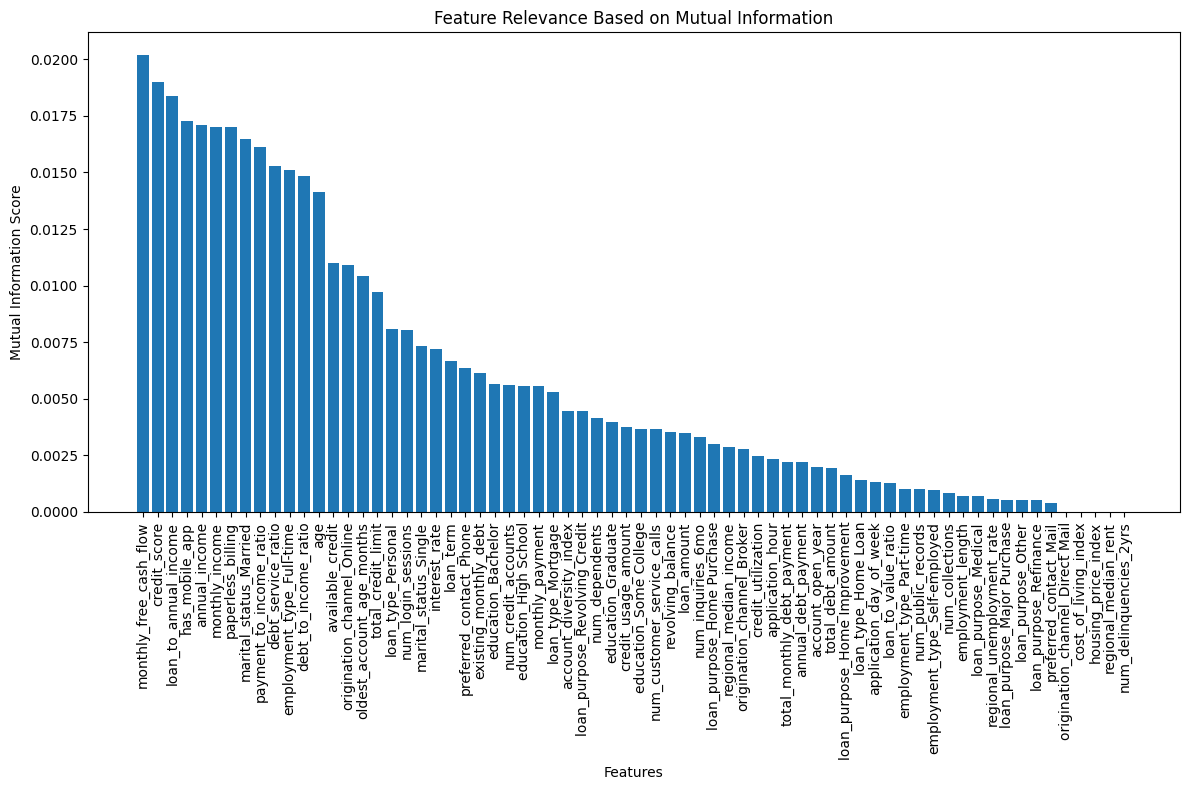

In [109]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt

# ---- 1. Prepare numeric data ----
df_t = df.select_dtypes('number').copy()
fill_cols = ['num_delinquencies_2yrs', 'revolving_balance', 'employment_length']
df_t[fill_cols] = df_t[fill_cols].fillna(0.0)

X = df_t.drop("default", axis=1)
y = df_t["default"]

# ---- 2. Calculate Mutual Information scores ----
mi_scores = mutual_info_classif(X, y, random_state=42)

# ---- 3. Put into DataFrame ----
mi_df = pd.DataFrame({
    "feature": X.columns,
    "mi_score": mi_scores
}).sort_values(by="mi_score", ascending=False)

# ---- 4. Filter features with MI >= 0.99 ----
high_mi_features = mi_df[mi_df["mi_score"] >= 0.0099]["feature"].tolist()
print("Features with MI >= 0.99:", high_mi_features)

# ---- 5. Optional: Plot MI scores ----
plt.figure(figsize=(12, 8))
plt.bar(mi_df["feature"], mi_df["mi_score"])
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Mutual Information Score")
plt.title("Feature Relevance Based on Mutual Information")
plt.tight_layout()
plt.show()

In [110]:
high_mi_features

['monthly_free_cash_flow',
 'credit_score',
 'loan_to_annual_income',
 'has_mobile_app',
 'annual_income',
 'monthly_income',
 'paperless_billing',
 'marital_status_Married',
 'payment_to_income_ratio',
 'debt_service_ratio',
 'employment_type_Full-time',
 'debt_to_income_ratio',
 'age',
 'available_credit',
 'origination_channel_Online',
 'oldest_account_age_months']

In [111]:
df[high_mi_features]

,monthly_free_cash_flow,credit_score,loan_to_annual_income,has_mobile_app,annual_income,monthly_income,paperless_billing,marital_status_Married,payment_to_income_ratio,debt_service_ratio,employment_type_Full-time,debt_to_income_ratio,age,available_credit,origination_channel_Online,oldest_account_age_months
0,3819.230000,696,0.286408,1,61800,5150.00,1,1,0.115,0.258402,1,0.258,41,26886.9,0,273.6
1,977.260000,659,3.986014,1,28600,2383.33,1,1,0.425,0.589959,1,0.590,38,2267.8,0,42.0
2,1203.120000,662,0.449275,1,20700,1725.00,0,0,0.184,0.302539,1,0.303,18,19085.4,1,0.0
3,2093.436667,676,0.277070,1,31400,2616.67,1,0,0.090,0.199961,1,0.200,27,51180.0,1,108.0
4,1466.420000,678,0.292683,1,24600,2050.00,0,0,0.163,0.284673,1,0.285,26,25446.4,0,96.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89994,3384.160000,817,0.156293,0,72300,6025.00,1,0,0.086,0.438314,1,0.438,52,86919.6,0,98.4
89995,982.260000,745,0.825000,1,20000,1666.67,0,0,0.327,0.410646,1,0.411,61,28767.0,0,105.6
89996,919.806667,607,0.890000,1,20000,1666.67,1,1,0.370,0.448116,1,0.448,19,6057.3,1,12.0
89997,1153.560000,678,0.585000,0,20000,1666.67,0,1,0.211,0.307866,1,0.308,21,23783.4,0,36.0
